In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
# !ls /home/aistudio/data

In [2]:
# import moxing as mox
# mox.file.copy('refMaskModel6.zip', 'obs://data-mask-3544/refMaskModel6.zip')

In [3]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
# !ls /home/aistudio/work

In [4]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, you need to use the persistence path as the following:
# !mkdir /home/aistudio/external-libraries
# !pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [5]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可:
# Also add the following code, so that every time the environment (kernel) starts, just run the following code:
# import sys
# sys.path.append('/home/aistudio/external-libraries')

In [6]:
# #get data from obs
# import moxing as mox
# #下载一个OBS文件夹sub_dir_0，从OBS下载至本地Notebook（OBS -> 本地）
# mox.file.copy('obs://data-mask-3544/VOC_MASK.zip', '/home/ma-user/work/VOC_MASK.zip')


In [7]:
# 解压 原本project 自带的数据 to ./masks
!unzip VOC_MASK.zip 

'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [8]:
# unzip the new data
!unzip DATA/DATA1/JPEGImages.zip -d new_data/test/

'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


1. 路径修改-> 本地路径
2. 数据集的问题
3. 

In [10]:
import shutil
import os
in_path = 'dataset_cui/dataset1/JPEGImages'
out_path='VOC_MASK/JPEGImages/'
for filepath,dirnames,filenames in os.walk(in_path):   #在多级目录下找图片 
        for filename in filenames:
            str1 = filename.split('.')[0]
            str1_1 = filename.split('.')[1]
            if str1_1 == "jpg" or str1_1 == "jpeg" or str1_1 == "JPG" or str1_1 == "JPEG":
                shutil.copy(filepath + "/" + filename, out_path) #! 复制文件,从in_path到out_path
                #shutil.move() 移动文件  
            else:
                continue

导入 xml 文件 从自己的 到 project 初始的

In [11]:
work_dir = "dataset_cui/dataset1/Annotations/"  # self_xml文件所在的目录
new_dir = 'VOC_MASK/Annotations/'  # dst_xml 文件所在的目录

for parent, dirnames, filenames in os.walk(work_dir,  followlinks=True):
    for filename in filenames:
        file_path = os.path.join(parent, filename)
        file = open(file_path, "r+", encoding='UTF-8')
        newFile = open(new_dir+filename, "w", encoding='UTF-8') # filename
        print(new_dir+filename)
        for line in file.readlines():    # 读取文件的每一行
             #! 修改标签为我们自己设定的然后再copy过去
            if("FIRC" in line):
                line = line.replace("FIRC", "Unknown")
            if("person" in line): # 直接把 person 改了
                line = line.replace("person", "not_standard")
            newFile.writelines(line)
        print(filename)
        newFile.close()
        file.close()


# 导入cv,paddlepaddle库

In [12]:
!python -m pip install paddlepaddle-gpu==2.2.2.post101 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html
!pip install opencv-python

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in links: https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173, in _main
    status = self.run(options, args)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\pip\_internal\cli\req_command.py", line 203, in wrapper
    return func(self, options, args)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\pip\_internal\commands\install.py", line 315, in run
    requirement_set = resolver.resolve(
  File "C:\Users\Administrator\anaconda3\lib\site-packages\pip\_internal\resolution\resolvelib\resolver.py", line 94, in resolve
    result = self._result = resolver.resolve(
  File "C:\Users\Administrator\anaconda3\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 472, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "C:\Users\Administrator\anaconda3\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 341, in resolve
    self._add

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


#### 直接从这开始(如果数据处理好的话)

In [13]:
import xml.etree.cElementTree as ET
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import paddle
import paddle.fluid as fluid
import myyolo3net as mynet
import time
import random

In [14]:
# 基本参数
xmlDir = r"VOC_MASK/Annotations"
imgDir = r"VOC_MASK/JPEGImages"
xmlList = [os.path.join(xmlDir, f) for f in os.listdir(xmlDir)]
labelDic = {'face': 0, 'face_mask': 1,'not_standard':2}
BATCH_SIZE = 16 
imgSize = (448,448)  # w,h
iouLim = 0.1
# anchorBox = [(40, 160), (80, 210), (80, 400)]  # 前宽后高
anchorBox = [(40, 40), (120, 120), (220, 220)]  # 前宽后高
colNum = imgSize[1] // 32
rowNum = imgSize[0] // 32
anchorNum = len(anchorBox)
classNum = len(labelDic)
outDim = (5 + classNum) * anchorNum
learningRate = 1e-4
testSize=96
random.shuffle(xmlList)
xmlListTest=xmlList[-testSize:]
xmlList=xmlList[0:-testSize]

#!!! 没有轮数吗?

# 从xml读图片，标签
def loadXmlandImg(xmlDir, loadImg=False, imgDir=imgDir, resize=False):
    # 输出的size是一个元组（w，h），theObjs为列表，每一位是一个字典，键name->标签，键box->[xxyy]
    xml = ET.parse(xmlDir)
    size = (
        int(xml.find("size").find("width").text),
        int(xml.find("size").find("height").text)
    )

    objs = xml.findall("object")
    theObjs = []
    # 遍历每个物品框生成一堆字典
    for obj in objs:
        bndbox = obj.find("bndbox")
        boxXXYY = [int(bndbox.find("xmin").text), int(bndbox.find("xmax").text),
                   int(bndbox.find("ymin").text), int(bndbox.find("ymax").text)]
        if resize:
            boxXXYY[0] *= resize[0] / size[0]
            boxXXYY[1] *= resize[0] / size[0]
            boxXXYY[2] *= resize[1] / size[1]
            boxXXYY[3] *= resize[1] / size[1]
        theObjs.append({
            "label": labelDic[obj.find("name").text],
            "box": boxXXYY
        })
    # 选择是不是加载图片
    if loadImg:
        fileName = xml.find("filename").text
        fileName = os.path.join(imgDir, fileName)
        img = cv2.imread(fileName)
        if resize:
            img = cv2.resize(img, resize)
        img = (cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype("float32") / 255.0).transpose(2, 0, 1)
        return size, theObjs, img
    else:
        return size, theObjs




# 构造yolo3真实框，输入真实框和框数上限，输出一个（框数，4）的xywh数组
def yolo3GTBoxLabel(gtBoxes, resize,boxNum=50):
    # gtBoxes，一个字典，包含label:01234和box:[x,x,y,y]两个键值对
    # shape = d['shapes']

    thisLabel = [0 for i in range(boxNum)]
    gtBoxArr = [[0, 0, 0, 0] for i in range(boxNum)]

    # 遍历这个图的每一个真实框
    for i in range(min(len(gtBoxes),boxNum)):
        box = gtBoxes[i]
        points = box['box']
        x1 = points[0]
        x2 = points[1]
        y1 = points[2]
        y2 = points[3]
        label = box['label']
        gtx = (x1 + x2) / 2
        gty = (y1 + y2) / 2
        gtw = x2 - x1
        gth = y2 - y1
        gtBoxArr[i] = [gtx/resize[0], gty/resize[1], gtw/resize[0], gth/resize[1]]
        thisLabel[i] = label
    # print(gtBoxArr,thisLabel)
    return np.array(gtBoxArr, dtype="float32"), np.array(thisLabel, dtype="int32")


# s, o, i = loadXmlandImg(os.path.join(xmlDir, xmlList[0]), True, imgDir)
# print(i.shape)


# 定义画矩形框的程序
def draw_rectangle(bbox, currentAxis=None, edgecolor='k', facecolor='y', fill=False, linestyle='-'):
    # currentAxis，坐标轴，通过plt.gca()获取
    # bbox，边界框，包含四个数值的list， [x1, x2, y1, y2]
    # edgecolor，边框线条颜色
    # facecolor，填充颜色
    # fill, 是否填充
    # linestype，边框线型
    # patches.Rectangle需要传入左上角坐标、矩形区域的宽度、高度等参数
    if not currentAxis:
        currentAxis = plt.gca()
    rect = patches.Rectangle((bbox[0], bbox[2]), bbox[1] - bbox[0] + 1, bbox[3] - bbox[2] + 1, linewidth=1,
                             edgecolor=edgecolor, facecolor=facecolor, fill=fill, linestyle=linestyle)
    currentAxis.add_patch(rect)

# 就是从一个 文件名到各种信息的转变 -> reader 
def dataReader2(xmllist, img_size=imgSize):#? 需要给imgsize吗？？？？
    labels = []
    gtboxes = []
    imgs = []
    for i in xmllist:   #             路径。 1. 
        # 得到图片的size, obj(详细信息width,height) , img本身
        size, obj, img = loadXmlandImg(i, True, resize=img_size)
        imgs.append(img)
        # print(obj)
        box, label = yolo3GTBoxLabel(obj, resize=imgSize)
        labels.append(label)
        gtboxes.append(box)
    return np.array(gtboxes, dtype="float32"), np.array(labels, dtype="int32"), np.array(imgs, dtype="float32")


# 构建网络

maxGTbox = 50
paddle.enable_static()
inputImg = fluid.layers.data("image", shape=[None, 3, imgSize[1], imgSize[0]], dtype="float32")
# inputLabel = fluid.layers.data("label", shape=[None, anchorNum, 5 + classNum, rowNum, colNum], dtype="float32")
inputLabel = fluid.layers.data("label", shape=[None, maxGTbox], dtype="int32")
inputGtbox = fluid.layers.data("gtbox", shape=[None, maxGTbox, 4], dtype="float32")
(C0, C1, C2) = mynet.Darknet53(inputImg)  # 经过骨干网络提取特征
(r0, t0, P0) = mynet.yoloMain(C0, outDim)  # 得到yolo3的0级输出
r0_resize = fluid.layers.resize_nearest(input=r0, scale=2)
C1_New = fluid.layers.concat(input=[r0_resize, C1], axis=1)  # 和C1拼起来
(r1, t1, P1) = mynet.yoloMain(C1_New, outDim)  # yolo3的1级输出
r1_resize = fluid.layers.resize_nearest(input=r1, scale=2)
C1_New = fluid.layers.concat(input=[r1_resize, C2], axis=1)    # 和二级拼起来
(r2, t2, P2) = mynet.yoloMain(C1_New, outDim)
print(P0, P1, P2)

# lossAvg = mynet.yolo3LossNet(P0, inputLabel)
lossAll0 = fluid.layers.yolov3_loss( # 使用paddle框架自己的loss定义损失函数 !!!
    x=P0,
    gt_box=inputGtbox,
    gt_label=inputLabel,
    anchors=[7, 10, 12, 22, 24, 17,22, 45, 46, 33, 43, 88,85, 66, 115, 146, 275, 240],
    anchor_mask=[6,7,8],
    class_num=classNum,
    ignore_thresh=iouLim,
    downsample_ratio=32
)
lossAll1 = fluid.layers.yolov3_loss(
    x=P1,
    gt_box=inputGtbox,
    gt_label=inputLabel,
    anchors=[7, 10, 12, 22, 24, 17,22, 45, 46, 33, 43, 88,85, 66, 115, 146, 275, 240],
    anchor_mask=[3,4,5],
    class_num=classNum,
    ignore_thresh=iouLim,
    downsample_ratio=16
)
lossAll2 = fluid.layers.yolov3_loss(
    x=P2,
    gt_box=inputGtbox,
    gt_label=inputLabel,
    anchors=[7, 10, 12, 22, 24, 17,22, 45, 46, 33, 43, 88,85, 66, 115, 146, 275, 240],
    anchor_mask=[0, 1, 2],
    class_num=classNum,
    ignore_thresh=iouLim,
    downsample_ratio=8
)
lossAll = lossAll0 + lossAll1 + lossAll2
lossAvg = fluid.layers.mean(lossAll)
print(lossAvg)
testProgram = fluid.default_main_program().clone(for_test=True)
opt = fluid.optimizer.Momentum(
    learning_rate=fluid.layers.piecewise_decay(boundaries=[800,1500,4000], values=[1e-3,3e-4,1e-4,5e-5]),
    # learning_rate=1e-4,
    momentum=0.9,
    # regularization=fluid.regularizer.L2Decay(0.0005),
)
a=opt.minimize(lossAvg)
# 开始训练

var leaky_relu_58.tmp_0 : LOD_TENSOR.shape(-1, 24, 14, 14).dtype(float32).stop_gradient(False) var leaky_relu_65.tmp_0 : LOD_TENSOR.shape(-1, 24, 28, 28).dtype(float32).stop_gradient(False) var leaky_relu_72.tmp_0 : LOD_TENSOR.shape(-1, 24, 56, 56).dtype(float32).stop_gradient(False)


C:\Users\Administrator\anaconda3\lib\site-packages\paddle\fluid\layers\math_op_patch.py:336: UserWarning: C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_3932/470070166.py:175
The behavior of expression A + B has been unified with elementwise_add(X, Y, axis=-1) from Paddle 2.0. If your code works well in the older versions but crashes in this version, try to use elementwise_add(X, Y, axis=0) instead of A + B. This transitional warning will be dropped in the future.
  warnings.warn(


var mean_0.tmp_0 : LOD_TENSOR.shape(1,).dtype(float32).stop_gradient(False)


In [6]:
print("开始编译网络")
initPro = fluid.default_startup_program()
mainProg = fluid.default_main_program()

# place = fluid.CPUPlace() #use cpu???
place = fluid.CUDAPlace(0) #use gpu 
exe = fluid.Executor(place)
exe.run(program=initPro)

def testModel():
    miniBatch=4
    begin=0
    end=miniBatch
    lossAll=0.0
    while end<=testSize:
        b, l, ii = dataReader2(xmlListTest[begin:end])
        lo=exe.run(testProgram,
        feed={
                    'image': ii,
                    "label": l,
                    'gtbox': b
        },
        fetch_list=[lossAvg]
        )
        lossAll+=lo[0]
        # print(lo[0])
        begin+=miniBatch
        end+=miniBatch
    print("损失：",lossAll/(testSize//miniBatch))
        


开始编译网络


现在的问题:

如何不使用之前训练的模型而直接预测,这份代码是通过之前的训练过的模型基础上进行fine-tune而生成的,但是我们修改了之后就用不了之前的模型了，需要从0开始重新训练，那么如何修改代码是一个问题 !! 

已经解决:将下面cell中的第二行

#fluid.io.load_persistables(exe,'./model', mainProg) # 直接注释掉?

In [22]:
#os.environ['FLAGS_eager_delete_tensor_gb'] = "0.0"

In [27]:
# TODO ...
#fluid.io.load_persistables(exe,'./model', mainProg) # 直接注释掉?
print("开始训练")
dataNum = len(xmlList)
print(dataNum) 
# TODO 看看总长度是多少???
# 总次数 = 5 * dataNum/BATCH_SIZE * 1 = ? 
for i in range(15):# 训练5次?    0226:改为2次
    print("This is {} times in big FOR".format(i))
    testModel() # 之前定义的函数
    random.shuffle(xmlList) # 将序列中的元素随机打乱 -》 打乱xmlList
    tic = time.time() # 记录时间 
    begin = 0
    end = BATCH_SIZE
    while end <= dataNum: # 小于总数据num
        b, l, ii = dataReader2(xmlList[begin:end]) # 读取list内的内容
        # ['VOC_MASK/Annotations\\00535_Mask_Mouth_Chin.xml'] => np.array类型的容易得到的数据
        # print(b.shape, l.shape, i.shape)
        for j in range(1):
            la = exe.run(
                program=mainProg,
                feed={
                    'image': ii,
                    "label": l,
                    'gtbox': b
                },
                fetch_list=[lossAvg]
            )# exe.run() 返回什么??
        # print(la)
        if begin%128==0: # change here?
            print(i,begin,la, time.time() - tic) # 打印训练的各种信息，时间等等
            # 写一个详细的 tips !!! 
        begin += BATCH_SIZE # 280s 一次
        end += BATCH_SIZE
# 训练了2h+,还是不知道结果怎么样????
# 显示中间过程!! 
# 暂时保存模型
fluid.io.save_persistables(exe, './model', fluid.default_main_program())     
# 第二次 20-30s一个batch !!!
        
# b, l, i = dataReader2(xmlList[0:1])
# print(b.shape, l.shape, i.shape)

开始训练
8357
This is 0 times in big FOR
损失： [145.1584]
0 0 [array([157.99606], dtype=float32)] 2.188985824584961
0 128 [array([161.30981], dtype=float32)] 20.493324995040894
0 256 [array([142.18883], dtype=float32)] 38.795912742614746
0 384 [array([146.61853], dtype=float32)] 57.593847036361694
0 512 [array([147.26389], dtype=float32)] 76.47021675109863
0 640 [array([146.62448], dtype=float32)] 95.531170129776
0 768 [array([137.0969], dtype=float32)] 114.65670228004456
0 896 [array([153.5064], dtype=float32)] 134.0480535030365
0 1024 [array([130.37071], dtype=float32)] 152.8032624721527
0 1152 [array([139.43562], dtype=float32)] 171.62709999084473
0 1280 [array([128.29022], dtype=float32)] 190.3366003036499
0 1408 [array([123.8621], dtype=float32)] 209.22962617874146
0 1536 [array([125.26399], dtype=float32)] 227.8350429534912
0 1664 [array([130.24663], dtype=float32)] 247.04777002334595
0 1792 [array([126.76189], dtype=float32)] 265.89901208877563
0 1920 [array([121.833984], dtype=float3

训练到一半的时候就可以保存参数了!!!

In [26]:
# 保存模型
fluid.io.save_persistables(exe, './model', fluid.default_main_program())

In [28]:
# 保存预测模型
fluid.io.save_inference_model("./refMaskModel/",
                              feeded_var_names=['image'],
                              target_vars=[P0,P1,P2],
                              executor=exe)

['leaky_relu_58.tmp_0', 'leaky_relu_65.tmp_0', 'leaky_relu_72.tmp_0']

In [29]:
# 打包下载
!zip -r refMaskModel6.zip refMaskModel

  adding: refMaskModel/ (stored 0%)
  adding: refMaskModel/__model__ (deflated 98%)
  adding: refMaskModel/batch_norm_0.b_0 (deflated 4%)
  adding: refMaskModel/batch_norm_0.w_0 (deflated 5%)
  adding: refMaskModel/batch_norm_0.w_1 (deflated 3%)
  adding: refMaskModel/batch_norm_0.w_2 (deflated 5%)
  adding: refMaskModel/batch_norm_1.b_0 (stored 0%)
  adding: refMaskModel/batch_norm_1.w_0 (stored 0%)
  adding: refMaskModel/batch_norm_1.w_1 (stored 0%)
  adding: refMaskModel/batch_norm_1.w_2 (deflated 1%)
  adding: refMaskModel/batch_norm_10.b_0 (stored 0%)
  adding: refMaskModel/batch_norm_10.w_0 (stored 0%)
  adding: refMaskModel/batch_norm_10.w_1 (stored 0%)
  adding: refMaskModel/batch_norm_10.w_2 (deflated 1%)
  adding: refMaskModel/batch_norm_11.b_0 (deflated 3%)
  adding: refMaskModel/batch_norm_11.w_0 (deflated 2%)
  adding: refMaskModel/batch_norm_11.w_1 (deflated 2%)
  adding: refMaskModel/batch_norm_11.w_2 (deflated 5%)
  adding: refMaskModel/batch_norm_12.b_0 (stored 0%)
  a

In [ ]:
# 打包下载
!zip -r model_0226_maskDetection.zip model

In [7]:
#解压文件
!unzip refMaskModel6.zip

/home/ma-user/anaconda3/envs/python-3.7.10/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Archive:  refMaskModel6.zip
   creating: refMaskModel/
  inflating: refMaskModel/__model__  
  inflating: refMaskModel/batch_norm_0.b_0  
  inflating: refMaskModel/batch_norm_0.w_0  
  inflating: refMaskModel/batch_norm_0.w_1  
  inflating: refMaskModel/batch_norm_0.w_2  
 extracting: refMaskModel/batch_norm_1.b_0  
 extracting: refMaskModel/batch_norm_1.w_0  
 extracting: refMaskModel/batch_norm_1.w_1  
  inflating: refMaskModel/batch_norm_1.w_2  
 extracting: refMaskModel/batch_norm_10.b_0  
 extracting: refMaskModel/batch_norm_10.w_0  
 extracting: refMaskModel/batch_norm_10.w_1  
  inflating: refMaskModel/batch_norm_10.w_2  
  inflating: refMaskModel/batch_norm_11.b_0  
  inflating: refMaskModel/batch_norm_11.w_0  
  inflating: refMaskModel/batch_norm_11.w_1  
  inflating: refMaskModel/batch_norm_11.w_2  
 extracting: refMaskModel/batch_norm_12.b_0  
 extracting: refMaskModel/batch_norm_12.w_0  
 extracting: refMaskModel/batch_norm_12.w_1  
  inflating: refMaskModel/batch_norm_12.w

In [6]:
fluid.io.load_persistables(exe,'./model', mainProg) # 直接注释掉?

开始运行
0.4866981506347656
{'bbox': [98.60502897670506, 337.26506686134155, 56.40422261706736, 293.63783871321124], 'obj': 0.9963109888304218, 'state': 2, 'class': 1, 'stride': 32}


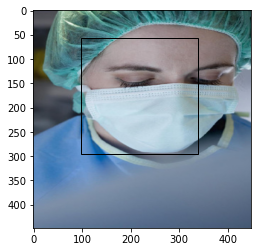

In [15]:
# 预测模型
import cv2
import numpy as np
import paddle.fluid as fluid
import time
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches

print("开始运行")

fluid.Scope()

## 加载所有文件的路径，每个文件在数组中有一位
modelPath = r'refMaskModel'
dataMap = {'face': 0, 'face_mask': 1,'not_rule':2}  #这里应该有三种预测，
classNum = 3          #这也应该为3
limObj = 0.8
iouLim=0.1

## 加载模型
place = fluid.CUDAPlace(0)
mainProg = fluid.default_main_program()
exe = fluid.Executor(place)


#fluid.io.load_inference_model载入我们训练的模型

[inference_program,  # 预测用的program
 feed_target_names,  # 一个str列表，它包含需要在预测 Program 中提供数据的变量的名称。
 fetch_targets] = fluid.io.load_inference_model(
    modelPath,
    exe
)


# 测试模型

def loadImg(path):
    img = cv2.imread(path)
    # print(img)
    img = cv2.resize(img, (448, 448), interpolation=cv2.INTER_AREA)
    img = (cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype("float32") / 255.0).transpose(2, 0, 1)
    return np.array([img], dtype="float32")


def sigma(x):
    return 1 / (1 + math.exp(-x))


def draw_rectangle(bbox, currentAxis=None, edgecolor='k', facecolor='y', fill=False, linestyle='-'):
    # currentAxis，坐标轴，通过plt.gca()获取
    # bbox，边界框，包含四个数值的list， [x1, x2, y1, y2]
    # edgecolor，边框线条颜色
    # facecolor，填充颜色
    # fill, 是否填充
    # linestype，边框线型
    # patches.Rectangle需要传入左上角坐标、矩形区域的宽度、高度等参数
    if not currentAxis:
        currentAxis = plt.gca()
    rect = patches.Rectangle((bbox[0], bbox[2]), bbox[1] - bbox[0] + 1, bbox[3] - bbox[2] + 1, linewidth=1,
                             edgecolor=edgecolor, facecolor=facecolor, fill=fill, linestyle=linestyle)
    currentAxis.add_patch(rect)


    #求交并比，计算两个矩形的交并比，通常在检测任务里面可以作为一个检测指标。你的预测bbox和groundtruth之间的差异，就可以通过IOU来体现。
def getIOU(xxyy1, xxyy2):
    x2 = min(xxyy1[1], xxyy2[1])
    x1 = max(xxyy1[0], xxyy2[0])
    y1 = max(xxyy1[2], xxyy2[2])
    y2 = min(xxyy1[3], xxyy2[3])

    if (x2 < x1) or (y1 > y2):
        return 0.0
    else:
        i = (x2 - x1) * (y2 - y1)
        s1 = (xxyy1[1] - xxyy1[0]) * (xxyy1[3] - xxyy1[2])
        s2 = (xxyy2[1] - xxyy2[0]) * (xxyy2[3] - xxyy2[2])
        return i / (s1 + s2 - i)


def refImg(imgPath):
    # maybeBox = [[] for i in range(classNum)]
    maybeBox = []
    img = loadImg(imgPath)

    def logBox(pred, stride, archors):
        pred0_ = pred[0]
        archorNum = len(archors) // 2
        for i in range(pred0_.shape[1]):
            for j in range(pred0_.shape[2]):
                for p in range(archorNum):
                    if sigma(pred0_[4 + p * (5 + classNum), i, j]) > limObj:
                        res = pred0_[p * (5 + classNum):(p + 1) * (5 + classNum), i, j]
                        x = stride * (j + sigma(res[0]))
                        y = stride * (i + sigma(res[1]))
                        w = archors[p * 2] * math.exp(res[2])
                        h = archors[p * 2 + 1] * math.exp(res[3])
                        max_ = (-1000)
                        maxClass = -1
                        # 比较是脸还是口罩
#                         if res[5] > res[6]:
#                             maxClass = 0
#                         else:
#                             maxClass = 1

                        for c in range(5, 5 + classNum):
                            if res[c] > max_:
                                max_ = res[c]
                                maxClass = c - 5

                        maybeBox.append({
                            "bbox": [x - w / 2, x + w / 2, y - h / 2, y + h / 2],
                            "obj": sigma(res[5 + maxClass]),
                            "state": 0,
                            "class": maxClass,
                            "stride": stride
                        })

    tic = time.time()
    pred0, pred1, pred2 = exe.run(
        program=inference_program,
        feed={feed_target_names[0]: img},
        fetch_list=fetch_targets
    )
    print(time.time() - tic)
    logBox(pred0, stride=32, archors=[85, 66, 115, 146, 275, 240])
    logBox(pred1, stride=16, archors=[22, 45, 46, 33, 43, 88])
    logBox(pred2, stride=8, archors=[7, 10, 12, 22, 24, 17])
    # print(maybeBox)
    plt.imshow(img[0].transpose(1, 2, 0))
    # goodBox0 = [[] for i in range(classNum)]
    # 去除多余的框
    # for i in range(classNum):
    while True:
        finish = True
        max_ = -1
        maxBox = 0
        for box in maybeBox:
            if box["state"] == 0 and box["obj"] > max_:
                finish = False
                max_ = box["obj"]
                maxBox = box
        if not finish:
            maxBox["state"] = 2
        for box in maybeBox:
            if box["state"] == 0 and getIOU(box["bbox"], maxBox["bbox"]) > 0.1:
                box["state"] = 1
        if finish:
            break

    # print("face")
    for box in maybeBox:
        if box["state"] == 2:
            print(box)
            if box["class"] == 0:
                draw_rectangle(box["bbox"], edgecolor='r')
            else:
                draw_rectangle(box["bbox"])

    # print("facemask")
    # for box in maybeBox[1]:
    #     if box["state"] == 2:
    #         print(box)
    #         draw_rectangle(box["bbox"])

    plt.show()

#  
# todo 修改展示函数!!!! evaluate
refImg(r"./VOC_MASK/JPEGImages/test_00000331.jpg") # 不规范
# 4_Dancing_Dancing_4_6
# refImg(r"./VOC_MASK/JPEGImages/1_Handshaking_Handshaking_1_341.jpg")
# refImg(r"./VOC_MASK/JPEGImages/00002_Mask_Mouth_Chin.jpg")



In [ ]:
import cv2
import time

cap=cv2.VideoCpature

In [13]:
!ls

3230486.ipynb	     home   myyolo3net.py  refMaskModel       VOC_MASK
cui_mask_test.ipynb  model  __pycache__    refMaskModel6.zip  VOC_MASK.zip


In [ ]:
# for i in range(1,15):
#     refImg("mymask/%d.jpg"%i)